## Import Dependencies

 Could you please include age, gender and BMI to the model and Table 1, please?
- Can you filter the lab values based on the probable ranges for lab and vital signs to make sure we don't have any implausible values included?
- Francesca noticed in your code that at one point you imputed missing values with -1, is that correct? If so, should we rather impute with mean/median or other imputation methods that are more robust?
- Could you please add the feature importance so we can see if they differ for Mimic/Catalunya if we build a new model in Catalunya?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tableone import TableOne
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, auc
import os
import pydata_google_auth
import pickle

## Authenticate with GCP to access MIMIC

In [2]:
project_id = 'authentic-light-375118'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

credentials = pydata_google_auth.get_user_credentials(
    ['https://www.googleapis.com/auth/bigquery'],
    use_local_webserver=False
)

def run_query(query):
    return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      credentials=credentials,
      configuration={'query': {
          'useLegacySql': False
      }})

## Cohort Curation
#### Inclusion/Exclusion Criteria
1. Patients > 18
2. 1st ICU stay
3. Measurement of creatinine and urine ouput within 24 hours
4. aki stage 2 
5. not a CEER ICD 10-N18
6. No DNR

#### AKI Stage > 0

In [3]:
# Base the cohort off of patients with aki_stage > 0.
aki = run_query(
    """SELECT * FROM `physionet-data.mimiciv_derived.kdigo_stages` WHERE aki_stage <> 0"""
)

In [4]:
aki_pats = aki['subject_id'].unique()
len(aki_pats)

34862

#### First ICU Stay

In [5]:
# Get the ICU stays of the AKI patients and select the first one.
icustays = run_query(
    f"""SELECT * FROM `physionet-data.mimiciv_icu.icustays` WHERE subject_id IN {str(tuple(aki_pats))}"""
)
icustays.shape

(55223, 8)

In [6]:
# Returns the first ICU stay for each patient.
def get_first_icu_stay(df):
    min_stay = df.groupby(by='subject_id')['intime'].min().reset_index()
    result = df.merge(min_stay)
    return result

icu_first = get_first_icu_stay(icustays)
icu_first.shape

(34862, 8)

In [7]:
icu_first.nunique()

subject_id        34862
hadm_id           34862
stay_id           34862
first_careunit        9
last_careunit         9
intime            34861
outtime           34862
los               33653
dtype: int64

In [8]:
aki_icu = aki.merge(icu_first, on=['subject_id', 'hadm_id', 'stay_id'])
aki_icu.shape

(632562, 20)

aki_icu

In [9]:
aki_icu.nunique()

subject_id              32032
hadm_id                 32032
stay_id                 32032
charttime              502668
creat_low_past_7day       183
creat_low_past_48hr       190
creat                     219
aki_stage_creat             4
uo_rt_6hr               10782
uo_rt_12hr              15925
uo_rt_24hr              18348
aki_stage_uo                4
aki_stage_crrt              1
aki_stage                   3
aki_stage_smoothed          3
first_careunit              9
last_careunit               9
intime                  32031
outtime                 32032
los                     31037
dtype: int64

#### Filter out patients with DNR request

In [10]:
aki_icu_enc = aki_icu['hadm_id'].unique()

In [11]:
# Get patients with DNR in the current cohort.
dnr = run_query(
    f"""SELECT hadm_id from `physionet-data.mimiciv_icu.chartevents` WHERE itemid=22378 or itemid=228687 
    AND hadm_id IN {str(tuple(aki_icu_enc))}"""
)
dnr.shape

(2421, 1)

In [12]:
aki_no_dnr = aki_icu[~aki_icu.isin(dnr['hadm_id'].values)]
aki_icu.shape

(632562, 20)

#### Creatinine and Urine Output within 24 hours of admission

In [13]:
aki_no_dnr_sid = aki_no_dnr['stay_id'].unique()

In [14]:
# Get creatinine and urine output values for the current cohort.
creatinine = run_query(
    f"""SELECT * FROM `physionet-data.mimiciv_derived.kdigo_creatinine` WHERE stay_id IN 
    {str(tuple(aki_no_dnr_sid))}"""
)
uo = run_query(
    f"""SELECT * FROM `physionet-data.mimiciv_derived.kdigo_uo` WHERE stay_id IN 
    {str(tuple(aki_no_dnr_sid))}
    """
)

In [15]:
# Find stay_ids that do not have a creatinine or uo value within 24 hours.
cohort_sid_intime = aki_no_dnr[['stay_id', 'intime']].drop_duplicates()
cohort_sid_intime.shape

(32032, 2)

In [16]:
cohort_sid_intime.nunique()

stay_id    32032
intime     32031
dtype: int64

In [17]:
# Merge with intime
creatinine_icu = cohort_sid_intime.merge(creatinine, on='stay_id', how='left')
uo_icu = cohort_sid_intime.merge(uo, on='stay_id', how='left')
print(creatinine_icu.nunique())
print(uo_icu.nunique())

stay_id                 32032
intime                  32031
hadm_id                 32032
charttime              297575
creat                     286
creat_low_past_48hr       251
creat_low_past_7day       242
dtype: int64
stay_id              32032
intime               32031
charttime           879527
weight                1714
urineoutput_6hr       3372
urineoutput_12hr      5376
urineoutput_24hr      9117
uo_rt_6hr            54988
uo_rt_12hr           50338
uo_rt_24hr           46278
uo_tm_6hr             4158
uo_tm_12hr            4942
uo_tm_24hr            6239
dtype: int64


In [18]:
# Calculate delta between intime and charttime in days.
creatinine_icu['delta_days'] = (creatinine_icu['charttime'] - creatinine_icu['intime']) / np.timedelta64(1, 'D')
uo_icu['delta_days'] = (uo_icu['charttime'] - uo_icu['intime']) / np.timedelta64(1, 'D')

In [19]:
creatinine_icu['delta_days'].describe()

count    299546.000000
mean          3.655584
std           7.258433
min          -6.999803
25%           0.095747
50%           1.411806
75%           4.845139
max         101.209722
Name: delta_days, dtype: float64

In [20]:
uo_icu['delta_days'].describe()

count    1.977128e+06
mean     5.343388e+00
std      7.336680e+00
min     -2.981181e+01
25%      1.086042e+00
50%      2.748628e+00
75%      6.687266e+00
max      1.015424e+02
Name: delta_days, dtype: float64

In [21]:
# Filter for measurements within 48 hours.
creatinine_icu_48 = creatinine_icu[(creatinine_icu['delta_days'] >= 0) & (creatinine_icu['delta_days'] <= 2)]
uo_icu_48 = uo_icu[(uo_icu['delta_days'] >= 0) & (uo_icu['delta_days'] <= 2)]

In [22]:
# Use set intersection to find ids that match by criterion. 
sids_48 = list(set(creatinine_icu_48['stay_id'].unique()).intersection(set(uo_icu_48['stay_id'].unique())))
len(sids_48)

31177

In [23]:
# Stays lost
len(aki_no_dnr_sid) - len(sids_48)

855

In [24]:
aki_creat_uo_48 = aki_no_dnr[aki_no_dnr['stay_id'].isin(sids_48)].reset_index(drop=True)
aki_creat_uo_48.shape

(623592, 20)

#### Patients greater than 18

In [25]:
aki_creat_uo_48_pats = aki_creat_uo_48['subject_id'].unique()

In [26]:
# Query patients in our current cohort under 18.
demo = run_query(
    f"""SELECT * FROM `physionet-data.mimiciv_hosp.patients` WHERE subject_id IN {str(tuple(aki_creat_uo_48_pats))} """
)

In [27]:
demo_18 = demo[demo['anchor_age'] < 18]

In [28]:
# No patients match so we can ignore this criteria.
demo_18.shape[0]

0

#### Filter to a single sample per patient.
Idea: Max AKI stage in the 1st 48 hours of the stay.
If duplicates, take the one closest to the intime.

In [29]:
# Calculate delta days.
aki_creat_uo_48['delta_hours_aki'] = (aki_creat_uo_48['charttime'] - aki_creat_uo_48['intime']) / np.timedelta64(1, 'h')

In [30]:
aki_creat_uo_48['delta_hours_aki'].describe()

count    623592.000000
mean        127.298270
std         182.414859
min        -691.454722
25%          26.302986
50%          59.040000
75%         150.716667
max        2286.089722
Name: delta_hours_aki, dtype: float64

In [31]:
cohort_48 = aki_creat_uo_48[(aki_creat_uo_48['delta_hours_aki'] >= 0) & (aki_creat_uo_48['delta_hours_aki'] <= 12)].reset_index(drop=True)

In [32]:
max_aki_48 = cohort_48.groupby(by='stay_id')['aki_stage'].max().reset_index().rename({'index' : 'stay_id'}, axis=1)

In [33]:
cohort_max_aki = aki_creat_uo_48.merge(max_aki_48)

In [34]:
# Select the min chart time.
min_chart = cohort_max_aki.groupby('stay_id')['charttime'].min().reset_index().rename({'index' : 'stay_id'}, axis=1)

In [35]:
cohort = cohort_max_aki.merge(min_chart)

In [36]:
# Drop NaN on hadm_id as NaN hadm_id's represent outpatients.
cohort = cohort.dropna(subset=['hadm_id'])
cohort.shape

(12437, 21)

## Add Covariates

#### Labs
- K+
- pH
- BUN
- HCO3

In [37]:
cohort_enc = cohort['hadm_id'].unique()
labs = run_query(
    f"""SELECT * FROM (select l.*, d.label from `physionet-data.mimiciv_hosp.labevents` AS l
        JOIN `physionet-data.mimiciv_hosp.d_labitems` d ON l.itemid = d.itemid WHERE 
        l.itemid IN (51006, 50822, 50971, 50810, 51221, 50912, 50862, 50820, 50882, 50803)
        ) 
        WHERE hadm_id IN {str(tuple(cohort_enc))}"""
)

In [38]:
labs.shape

(1233458, 17)

In [39]:
cohort_ts = cohort[['stay_id', 'hadm_id', 'intime', 'outtime']].drop_duplicates()

In [40]:
# Convert dates to datetime.
cohort_ts['intime'] = pd.to_datetime(cohort_ts['intime'])
cohort_ts['outtime'] = pd.to_datetime(cohort_ts['outtime'])
labs['charttime'] = pd.to_datetime(labs['charttime'])

In [41]:
# Filter labs to only keep those whose charttime is between an admissions intime and outtime. 
labs_merged = labs.merge(cohort_ts, on='hadm_id')
labs_filt = labs_merged[(labs_merged['charttime'] >= labs_merged['intime']) & (labs_merged['charttime'] <= labs_merged['outtime'])]
labs_filt.shape

(672786, 20)

In [42]:
# Pivot table to get the min and max values of labs. 
lab_description = pd.pivot_table(labs, values=['valuenum'], index=['hadm_id'], columns=['label'], aggfunc=[np.nanmin, np.nanmax])
lab_description = lab_description.reset_index()
# Restore correct columns.
cols = ["_".join(x) for x in list(lab_description)]
cols[0] = 'hadm_id'
lab_description.columns = cols

In [43]:
lab_description.head()

,hadm_id,nanmin_valuenum_Albumin,nanmin_valuenum_Bicarbonate,"nanmin_valuenum_Calculated Bicarbonate, Whole Blood",nanmin_valuenum_Creatinine,nanmin_valuenum_Hematocrit,"nanmin_valuenum_Hematocrit, Calculated",nanmin_valuenum_Potassium,"nanmin_valuenum_Potassium, Whole Blood",nanmin_valuenum_Urea Nitrogen,...,nanmax_valuenum_Albumin,nanmax_valuenum_Bicarbonate,"nanmax_valuenum_Calculated Bicarbonate, Whole Blood",nanmax_valuenum_Creatinine,nanmax_valuenum_Hematocrit,"nanmax_valuenum_Hematocrit, Calculated",nanmax_valuenum_Potassium,"nanmax_valuenum_Potassium, Whole Blood",nanmax_valuenum_Urea Nitrogen,nanmax_valuenum_pH
0,20000094,3.1,19.0,NaN,3.8,40.1,NaN,4.3,NaN,99.0,...,3.6,28.0,NaN,3.9,42.1,NaN,4.6,NaN,99.0,7.41
1,20001305,2.6,21.0,NaN,0.8,31.4,NaN,4.1,NaN,47.0,...,2.6,25.0,NaN,1.2,34.5,NaN,4.7,NaN,59.0,7.46
2,20001361,3.0,20.0,NaN,1.6,30.6,NaN,3.4,NaN,24.0,...,3.2,26.0,NaN,4.2,37.2,NaN,5.8,NaN,49.0,7.48
3,20001770,2.0,15.0,NaN,0.7,19.9,NaN,3.4,3.4,9.0,...,3.0,22.0,NaN,1.7,28.4,NaN,5.2,3.4,23.0,7.26
4,20002506,4.9,22.0,NaN,0.6,33.7,NaN,3.4,NaN,6.0,...,4.9,26.0,NaN,0.7,40.0,NaN,4.1,NaN,13.0,NaN


In [44]:
cohort_icu_labs = cohort.merge(lab_description, on='hadm_id')

In [45]:
cohort_icu_labs.shape

(12432, 41)

#### SOFA Score
Select SOFA closest to icu admission.

In [46]:
cohort_sid = cohort_icu_labs['stay_id'].unique()

In [47]:
# Query SOFA scores for the selected stays.
sofa = run_query(
    f"""SELECT stay_id, hr, starttime, endtime, sofa_24hours
    FROM `physionet-data.mimiciv_derived.sofa` WHERE stay_id IN {str(tuple(cohort_sid))}"""
)

In [48]:
sofa.shape

(1328389, 5)

In [49]:
sofa_48 = sofa[sofa['hr'] <= 48]

In [50]:
sofa_48_min = dict(sofa_48.groupby(by='stay_id')['hr'].min())

In [51]:
sofa['min_hour'] = sofa['stay_id'].map(sofa_48_min)

In [52]:
sofa = sofa[sofa['min_hour'] == sofa['hr']]
sofa.shape

(12432, 6)

In [53]:
cohort_sofa = cohort_icu_labs.merge(sofa, on='stay_id', how='left')
cohort_sofa.shape

(12432, 46)

#### Antibiotics

In [54]:
## Use lowercase first
# modify quesry to with % % 

In [55]:
antib = run_query(
    f"""
    SELECT a.stay_id, a.starttime, a.route, a.antibiotic FROM `physionet-data.mimiciv_derived.antibiotic` AS a
    where (lower(a.antibiotic) like "vancomycin" or a.antibiotic like 
    "Gentamicin" or a.antibiotic like "vancocin" 
    or a.antibiotic like "Gentamicin (Bulk)" or a.antibiotic like 'NEO*IV*Gentamicin' 
    or a.antibiotic like 'NEO*IV*Vancomycin' or a.antibiotic like 'Gentamicin Sulfate') AND
    a.stay_id IN {str(tuple(cohort_sid))}
    """
)
antib.shape

(17525, 4)

In [56]:
antib['antibiotic'] = 1

In [57]:
cohort_stay_intime = cohort_sofa[['stay_id', 'intime']].drop_duplicates()
antib['starttime'] = pd.to_datetime(antib['starttime'])
antib = antib.dropna(subset='stay_id')
antib_intime_stayid = cohort_stay_intime.merge(antib, on='stay_id')
antib_intime_stayid['delta_days'] = (antib_intime_stayid['starttime'] - antib_intime_stayid['intime']) / np.timedelta64(1, 'D')
antib_intime_stayid_48 = antib_intime_stayid[antib_intime_stayid['delta_days'] <= 2]
antib_intime_stayid_48 = antib_intime_stayid_48.drop_duplicates(subset=['stay_id'])
antib_intime_stayid_48 = antib_intime_stayid_48[['stay_id', 'antibiotic']]
cohort_antib = cohort_sofa.merge(antib_intime_stayid_48, on='stay_id', how='left')
cohort_antib['antibiotic'].fillna(0, inplace=True)
cohort_antib.shape

(12432, 47)

In [58]:
cohort_antib['antibiotic'].value_counts()

0.0    7436
1.0    4996
Name: antibiotic, dtype: int64

#### Sepsis

In [59]:
sepsis = run_query(
    f"""
    SELECT stay_id, sepsis3 FROM `physionet-data.mimiciv_derived.sepsis3` WHERE
    stay_id IN {str(tuple(cohort_sid))}
    """
)
sepsis.shape

(7308, 2)

In [60]:
sepsis.drop_duplicates(inplace=True)
sepsis.shape

(7308, 2)

In [61]:
cohort_sepsis = cohort_antib.merge(sepsis, on='stay_id', how='left')
cohort_sepsis['sepsis3'].value_counts(dropna=False)
cohort_sepsis['sepsis3'].fillna(False, inplace=True)
cohort_sepsis.shape

(12432, 48)

#### Vitals
- Heart Rate
- MBP
- MBP_NI
- Resp Rate
- SPo2

In [62]:
# Query requested vitals attributes for the cohort.
cohort_sids = cohort_sepsis['stay_id'].unique()
vitals = run_query(
    f"""
    SELECT stay_id, charttime, heart_rate, mbp, mbp_ni, resp_rate, spo2
    FROM `physionet-data.mimiciv_derived.vitalsign` WHERE stay_id IN 
    {str(tuple(cohort_sids))}
    """
)

In [63]:
# Get min and max vitals.
agg_cols = ['heart_rate', 'mbp', 'mbp_ni', 'resp_rate', 'spo2']
vitals_min = vitals.groupby('stay_id')[agg_cols].min().reset_index()
vitals_min.rename(dict(zip(agg_cols, ['min_' + x for x in agg_cols])), axis=1, inplace=True)
vitals_max = vitals.groupby('stay_id')[agg_cols].max().reset_index()
vitals_max.rename(dict(zip(agg_cols, ['max_' + x for x in agg_cols])), axis=1, inplace=True)

In [64]:
cohort_vitals = cohort_sepsis.merge(vitals_min, on='stay_id', how='left')
cohort_vitals = cohort_vitals.merge(vitals_max, on='stay_id', how='left')

In [65]:
cohort_vitals.shape

(12432, 58)

#### Comorbdities
- CKD
- Hypotension
- Heart Failure
- Diabetes

In [66]:
# Query all icd codes for our cohort.
cohort_enc = cohort_vitals['hadm_id'].unique()
icdcodes = run_query(
    f"""
    SELECT * FROM `physionet-data.mimiciv_hosp.diagnoses_icd` WHERE 
    hadm_id IN {str(tuple(cohort_enc))}
    """
)
icdcodes.shape

(242334, 5)

In [67]:
"""
Functions for calculating comorbidities based on ICD9/10 codes.
"""
def is_DM(row):
    
    if row.icd_version== 9:
        if row.icd_code == 7751:
            return 1 
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 25000 and pd.to_numeric(row.icd_code, errors= "coerce") <= 25033:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64800 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64804:
            return 1
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 24900 and pd.to_numeric(row.icd_code, errors= "coerce") <= 24931:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 25040 and pd.to_numeric(row.icd_code, errors= "coerce") <= 25093:
            return 1
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 24940 and pd.to_numeric(row.icd_code, errors= "coerce") <= 24991:
            return 1
        else:
            return 0 
        
    if row.icd_version== 10:       
        if row.icd_code.startswith('E08') or row.icd_code.startswith('E09') or row.icd_code.startswith('E10') or row.icd_code.startswith('E11') or row.icd_code.startswith('E12') or row.icd_code.startswith('E13'):
            return 1      
        else:
            return 0

def is_HF(row): #heart failure
    if row.icd_version== 9:
        if pd.to_numeric(row.icd_code, errors= "coerce") == 4280 or pd.to_numeric(row.icd_code, errors= "coerce") == 4281 or pd.to_numeric(row.icd_code, errors= "coerce") == 4289 or pd.to_numeric(row.icd_code, errors= "coerce")==39891:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 42820 and pd.to_numeric(row.icd_code, errors= "coerce") <= 42823:
            return 1
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 42830 and pd.to_numeric(row.icd_code, errors= "coerce") <= 42832:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 42840 and pd.to_numeric(row.icd_code, errors= "coerce") <= 42843:
            return 1
        else:
            return 0 
        
    if row.icd_version== 10:
        if row.icd_code.startswith('I13') or row.icd_code.startswith('I11') or row.icd_code.startswith('I25') or row.icd_code.startswith('I46') or row.icd_code.startswith('I50') or row.icd_code.startswith('I42') or row.icd_code.startswith('I43')  or row.icd_code.startswith('I44'):
            return 1      
        else:
            return 0

# Hypertension -icd 9 and 10 
def is_Hypert(row): 
    
    l=[4010,4011,4019,4372,40200,40210,40290,40509,40519,40201,40211,40291,40310,40300,40390,40501,40511,
       40591,40301,40311,40391,40400,40410,40490,40401,40411,40491,40402,40412,40492,40403,40413,40493]
    
    if row.icd_version== 9:

        if pd.to_numeric(row.icd_code, errors= "coerce") in l:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64200 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64204:
            return 1
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64220 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64224:
            return 1      
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64210 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64214:
            return 1
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64270 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64274:
            return 1   
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 64290 and pd.to_numeric(row.icd_code, errors= "coerce") <= 64294:
            return 1   
        else:
            return 0 
        
    if row.icd_version== 10:
        if row.icd_code.startswith('I10') or row.icd_code.startswith('I15') or row.icd_code.startswith('I16'):
            return 1      
        else:
            return 0

def is_CKD(row):
    if row.icd_version== 9:
        
        if pd.to_numeric(row.icd_code, errors= "coerce") >= 5851 and pd.to_numeric(row.icd_code, errors= "coerce") <= 5856:
            return 1     
        if pd.to_numeric(row.icd_code, errors= "coerce") == 5859:
            return 1   
        else:
            return 0 
        
    if row.icd_version== 10:
        if row.icd_code.startswith('I12') or row.icd_code.startswith('I12') or row.icd_code.startswith('N01') or row.icd_code.startswith('N02') or row.icd_code.startswith('N03') or row.icd_code.startswith('N04') or row.icd_code.startswith('N05') or row.icd_code.startswith('N06') or row.icd_code.startswith('N07') or row.icd_code.startswith('N08') or row.icd_code.startswith('N11') or row.icd_code.startswith('N13')     or row.icd_code.startswith('N14') or row.icd_code.startswith('N15') or row.icd_code.startswith('N18') or row.icd_code.startswith('N19') or row.icd_code.startswith('N25') or row.icd_code.startswith('N26') or row.icd_code.startswith('N27') or row.icd_code.startswith('N28') or row.icd_code.startswith('N29'):
            return 1      
        else:
            return 0  

In [68]:
# Calculate binary labels on icd codes.
icdcodes['dm'] = icdcodes.apply(is_DM, axis=1)
icdcodes['heartfailure'] = icdcodes.apply(is_HF, axis=1)
icdcodes['hypertension'] = icdcodes.apply(is_Hypert, axis=1)
icdcodes['ckd'] = icdcodes.apply(is_CKD, axis=1)

In [69]:
# Get one value for every stay ID.
ckd   = icdcodes.groupby('hadm_id')['ckd'].max().reset_index()
dm    = icdcodes.groupby('hadm_id')['dm'].max().reset_index()
hyper = icdcodes.groupby('hadm_id')['hypertension'].max().reset_index()
hf    = icdcodes.groupby('hadm_id')['heartfailure'].max().reset_index()

In [70]:
# Construct comorbdities dataframe.
comorbidities = ckd.merge(dm, on='hadm_id', how='left')
comorbidities = comorbidities.merge(hyper, on='hadm_id', how='left')
comorbidities = comorbidities.merge(hf, on='hadm_id', how='left')
comorbidities = comorbidities.fillna(0)

In [71]:
cohort_covariates = cohort_vitals.merge(comorbidities, on='hadm_id', how='left')

## Merge with CRRT Labels
Criteria - Only consider patients that recieved CRRT after the first 12 hours and before the first 5 days of their ICU stay 

In [72]:
cohort_sid = cohort_covariates['stay_id'].unique()

In [73]:
crrt = run_query(
    f"""
    SELECT * FROM `physionet-data.mimiciv_derived.crrt` 
    WHERE stay_id IN {str(tuple(cohort_sid))}
    """
)
crrt.shape

(111719, 24)

In [74]:
cohort_ts = cohort_covariates[['stay_id', 'intime']].drop_duplicates()

In [75]:
crrt['charttime'] = pd.to_datetime(crrt['charttime'])
crrt_icu = crrt.merge(cohort_ts, on='stay_id')
crrt_icu['time_delta'] = (crrt_icu['charttime'] - crrt_icu['intime']) / np.timedelta64(1, 'h')
crrt_icu = crrt_icu[crrt_icu['charttime'] > crrt_icu['intime']].reset_index(drop=True)
min_crrt = crrt_icu.groupby('stay_id')['charttime'].min().reset_index()
crrt_min = crrt_icu.merge(min_crrt)
crrt_min.shape

(921, 26)

Text(0.5, 1.0, 'CRRT Incidence Distribution')

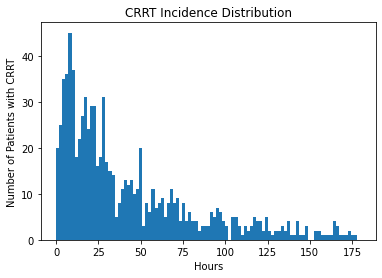

In [76]:
b= np.linspace(0, 180, 100)
plt.hist(crrt_min['time_delta'], bins=b)
plt.xlabel('Hours')
plt.ylabel('Number of Patients with CRRT')
plt.title('CRRT Incidence Distribution')

In [77]:
# Keep patients [0.5 days to 5 day window]
crrt_filt = crrt_min[(crrt_min['time_delta'] >= 24) &  (crrt_min['time_delta'] <= 144)].reset_index(drop=True)
crrt_filt.shape

(440, 26)

In [78]:
# Merge with CRRT Labels
crrt_filt['crrt'] = 1
crrt_filt = crrt_filt[['stay_id', 'crrt', 'time_delta']].drop_duplicates()
cohort_final = cohort_covariates.merge(crrt_filt, on='stay_id', how='left')
cohort_final['crrt'].fillna(0, inplace=True)

#### Merge with Demographics

In [79]:
cohort_pats = cohort_final['subject_id'].unique()
demo = run_query(
    f"""
        SELECT * from `physionet-data.mimiciv_hosp.patients` 
        WHERE subject_id IN {str(tuple(cohort_pats))}
    """
)
# Some demographic data is stored in admissions.
admissions = run_query(
    f"""
        SELECT * from `physionet-data.mimiciv_hosp.admissions` 
        WHERE subject_id IN {str(tuple(cohort_pats))}
    """
)

In [80]:
cohort_final = cohort_final.merge(demo, on='subject_id')
cohort_final = cohort_final.merge(admissions, on=['subject_id', 'hadm_id'])

In [81]:
# Cluster Races
targets = ['WHITE', 'BLACK', 'ASIAN', 'HISPANIC', 'OTHER']
for group in cohort_final['race'].unique():
    if 'WHITE' in group:
        cohort_final['race'] = cohort_final['race'].replace(group, 'WHITE')
    elif 'BLACK' in group:
        cohort_final['race'] = cohort_final['race'].replace(group, 'BLACK')
    elif 'ASIAN' in group:
        cohort_final['race'] = cohort_final['race'].replace(group, 'ASIAN')
    elif 'HISPANIC' in group:
        cohort_final['race'] = cohort_final['race'].replace(group, 'HISPANIC')
    elif 'UNKNOWN' in group:
        continue
    else:
        cohort_final['race'] = cohort_final['race'].replace(group, 'OTHER')
        

In [82]:
cohort_final['race'].value_counts()

WHITE       8346
UNKNOWN     1547
BLACK       1151
OTHER        749
HISPANIC     359
ASIAN        280
Name: race, dtype: int64

In [83]:
cohort_final.shape

(12432, 83)

### Calculate BMI using FirstDayWeight and FirstDayHeight

In [84]:
height = run_query(
    f"""
        SELECT * from `physionet-data.mimiciv_hosp.patients` 
        WHERE subject_id IN {str(tuple(cohort_pats))}
    """
)
# Some demographic data is stored in admissions.
weight = run_query(
    f"""
        SELECT * from `physionet-data.mimiciv_hosp.admissions` 
        WHERE subject_id IN {str(tuple(cohort_pats))}
    """
)

In [85]:
cohort_sid = cohort_final['stay_id'].unique()
bmi = run_query(f"""
 WITH bmi as (SELECT height.stay_id, POW(( weight.weight_admit / height.height), 2) as BMI
 FROM `physionet-data.mimiciv_derived.first_day_height` height JOIN
 `physionet-data.mimiciv_derived.first_day_weight` weight ON 
 height.stay_id = weight.stay_id)
 SELECT bmi.stay_id, bmi.BMI
 FROM bmi WHERE bmi.BMI is NOT NULL AND bmi.stay_id IN {str(tuple(cohort_sid))}
""")



In [86]:
cohort_final.shape

(12432, 83)

In [87]:
# Merge with bmi
cohort_final = cohort_final.merge(bmi, on='stay_id', how='left')

In [88]:
cohort_final.shape

(12432, 84)

In [89]:
cohort_final.to_csv('final_crrt_cohort.csv', index=False)

## Table 1

In [90]:
columns_all = ['first_careunit', 'creat_low_past_48hr', 'aki_stage', 'race','min_heart_rate',
 'min_mbp',
 'min_mbp_ni',
 'min_resp_rate',
 'min_spo2',
 'max_heart_rate',
 'max_mbp',
 'max_mbp_ni',
 'max_resp_rate',
 'max_spo2',
 'ckd',
 'dm',
 'hypertension',
 'heartfailure',
'nanmin_valuenum_Albumin',
 'nanmin_valuenum_Bicarbonate',
 'nanmin_valuenum_Calculated Bicarbonate, Whole Blood',
 'nanmin_valuenum_Creatinine',
 'nanmin_valuenum_Hematocrit',
 'nanmin_valuenum_Hematocrit, Calculated',
 'nanmin_valuenum_Potassium',
 'nanmin_valuenum_Potassium, Whole Blood',
 'nanmin_valuenum_Urea Nitrogen',
 'nanmin_valuenum_pH',
 'nanmax_valuenum_Albumin',
 'nanmax_valuenum_Bicarbonate',
 'nanmax_valuenum_Calculated Bicarbonate, Whole Blood',
 'nanmax_valuenum_Creatinine',
 'nanmax_valuenum_Hematocrit',
 'nanmax_valuenum_Hematocrit, Calculated',
 'nanmax_valuenum_Potassium',
 'nanmax_valuenum_Potassium, Whole Blood',
 'nanmax_valuenum_Urea Nitrogen',
 'nanmax_valuenum_pH',
 'sepsis3',
 'sofa_24hours',
 'antibiotic',
 'gender','BMI']

numerical_all =[
    'creat_low_past_48hr',
    'min_heart_rate',
    'min_mbp',
 'min_mbp_ni',
 'min_resp_rate',
 'min_spo2',
 'max_heart_rate',
 'max_mbp',
 'max_mbp_ni',
 'max_resp_rate',
 'max_spo2','nanmin_valuenum_Albumin',
 'nanmin_valuenum_Bicarbonate',
 'nanmin_valuenum_Calculated Bicarbonate, Whole Blood',
 'nanmin_valuenum_Creatinine',
 'nanmin_valuenum_Hematocrit',
 'nanmin_valuenum_Hematocrit, Calculated',
 'nanmin_valuenum_Potassium',
 'nanmin_valuenum_Potassium, Whole Blood',
 'nanmin_valuenum_Urea Nitrogen',
 'nanmin_valuenum_pH',
 'nanmax_valuenum_Albumin',
 'nanmax_valuenum_Bicarbonate',
 'nanmax_valuenum_Calculated Bicarbonate, Whole Blood',
 'nanmax_valuenum_Creatinine',
 'nanmax_valuenum_Hematocrit',
 'nanmax_valuenum_Hematocrit, Calculated',
 'nanmax_valuenum_Potassium',
 'nanmax_valuenum_Potassium, Whole Blood',
 'nanmax_valuenum_Urea Nitrogen',
 'nanmax_valuenum_pH',
        'sofa_24hours','BMI']

for col in numerical_all:
    cohort_final[col] = cohort_final[col].astype(np.float64)

categorical_all = [x for x in columns_all if x not in numerical_all]

tab = TableOne(cohort_final, columns=columns_all,categorical=categorical_all, groupby='crrt')

/home/jupyter-zaiman/.local/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),
/home/jupyter-zaiman/.local/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),
/home/jupyter-zaiman/.local/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq

In [91]:
# Display entire dataframe.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 100)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.precision', 5)

In [92]:
tab

Grouped by crrt                                          
                                                                                                                Missing         Overall       0.0           1.0          
n                                                                                                                                       12432         11992           440
first_careunit, n (%)                                          Cardiac Vascular Intensive Care Unit (CVICU)          0            1515 (12.2)   1443 (12.0)     72 (16.4)
                                                               Coronary Care Unit (CCU)                                           1510 (12.1)   1457 (12.1)     53 (12.0)
                                                               Medical Intensive Care Unit (MICU)                                 2869 (23.1)   2728 (22.7)    141 (32.0)
                                                               Medical/Surgical Intensive Care Unit (MICU/SICU)                   2276 (18.3)   2206 (18.4)     70 (15.9)
                                                               Neuro Intermediate                                                    88 (0.7)      88 (0.7)              
                                                               Neuro Stepdown                                                        49 (0.4)      49 (0.4)              
                                                               Neuro Surgical Intensive Care Unit (Neuro SICU)                      290 (2.3)     286 (2.4)       4 (0.9)
                                                               Surgical Intensive Care Unit (SICU)                                1974 (15.9)   1911 (15.9)     63 (14.3)
                                                               Trauma SICU (TSICU)                                                1861 (15.0)   1824 (15.2)      37 (8.4)
creat_low_past_48hr, mean (SD)                                                                                    8444              2.0 (2.3)     2.0 (2.2)     3.0 (2.7)
aki_stage, n (%)                                               1                                                     0           10268 (82.6)   9955 (83.0)    313 (71.1)
                                                               2                                                                  1542 (12.4)   1470 (12.3)     72 (16.4)
                                                               3                                                                    622 (5.0)     567 (4.7)     55 (12.5)
race, n (%)                                                    ASIAN                                                 0              280 (2.3)     270 (2.3)      10 (2.3)
                                                               BLACK                                                               1151 (9.3)    1110 (9.3)      41 (9.3)
                                                               HISPANIC                                                             359 (2.9)     342 (2.9)      17 (3.9)
                                                               OTHER                                                                749 (6.0)     716 (6.0)      33 (7.5)
                                                               UNKNOWN                                                            1547 (12.4)   1472 (12.3)     75 (17.0)
                                                               WHITE                                                              8346 (67.1)   8082 (67.4)    264 (60.0)
min_heart_rate, mean (SD)                                                                                            1            64.9 (15.3)   65.1 (15.2)   59.6 (15.8)
min_mbp, mean (SD)                                                                                                   3            51.2 (15.8)   51.7 (15.6)   37.6 (16.4)
min_mbp_ni, mean (SD)           

In [93]:
tab.to_csv('tableone_full.csv')

## Model Training

#### Baseline model
No strategy to handle class imbalance

In [94]:
data = cohort_final.copy()

In [95]:
# Select variables for the model.
columns = [
 'min_spo2',
 'max_spo2',
'nanmin_valuenum_Albumin',
 'nanmin_valuenum_Creatinine',
 'nanmin_valuenum_Hematocrit',
 'nanmin_valuenum_Potassium',
 'nanmin_valuenum_Urea Nitrogen',
 'nanmin_valuenum_pH',
 'nanmax_valuenum_Albumin',
 'nanmax_valuenum_Creatinine',
 'nanmax_valuenum_Hematocrit',
 'nanmax_valuenum_Potassium',
 'nanmax_valuenum_Urea Nitrogen',
 'nanmax_valuenum_pH',
'ckd' ,                                                     
  'dm',                                                    
 'hypertension',                                     
 'heartfailure',
    'race', 'gender', 'BMI'
]
categorical = ['ckd' ,                                                     
  'dm',                                                    
 'hypertension',                                     
 'heartfailure',
'race','gender'
]

numerical = [x for x in columns if x not in categorical]

In [96]:
len(columns)

21

In [97]:
data = data.dropna(subset=columns, how='any')

In [98]:
data.head()

,subject_id,hadm_id,stay_id,charttime,creat_low_past_7day,creat_low_past_48hr,creat,aki_stage_creat,uo_rt_6hr,uo_rt_12hr,uo_rt_24hr,aki_stage_uo,aki_stage_crrt,aki_stage,aki_stage_smoothed,first_careunit,last_careunit,intime,outtime,los,delta_hours_aki,nanmin_valuenum_Albumin,nanmin_valuenum_Bicarbonate,"nanmin_valuenum_Calculated Bicarbonate, Whole Blood",nanmin_valuenum_Creatinine,nanmin_valuenum_Hematocrit,"nanmin_valuenum_Hematocrit, Calculated",nanmin_valuenum_Potassium,"nanmin_valuenum_Potassium, Whole Blood",nanmin_valuenum_Urea Nitrogen,nanmin_valuenum_pH,nanmax_valuenum_Albumin,nanmax_valuenum_Bicarbonate,"nanmax_valuenum_Calculated Bicarbonate, Whole Blood",nanmax_valuenum_Creatinine,nanmax_valuenum_Hematocrit,"nanmax_valuenum_Hematocrit, Calculated",nanmax_valuenum_Potassium,"nanmax_valuenum_Potassium, Whole Blood",nanmax_valuenum_Urea Nitrogen,nanmax_valuenum_pH,hr,starttime,endtime,sofa_24hours,min_hour,antibiotic,sepsis3,min_heart_rate,min_mbp,min_mbp_ni,min_resp_rate,min_spo2,max_heart_rate,max_mbp,max_mbp_ni,max_resp_rate,max_spo2,ckd,dm,hypertension,heartfailure,crrt,time_delta,gender,anchor_age,anchor_year,anchor_year_group,dod,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,BMI
0,11818034,22420026,30463812,2185-05-10 06:49:00,3.4,3.4,3.7,1,None,None,None,<NA>,<NA>,1,1,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2185-05-09 23:20:28,2185-05-29 17:03:14,19.73803,7.47556,1.6,11.0,14.0,1.0,19.8,NaN,2.5,3.8,12.0,7.16,3.9,27.0,14.0,4.9,35.0,NaN,5.2,4.8,117.0,7.54,0,2185-05-09 23:00:00,2185-05-10 00:00:00,1.0,0,1.0,True,66.0,51.0,51.0,10.0,80.0,142.0,126.0,94.0,50.0,100.0,0.0,0.0,0.0,0.0,1.0,37.17556,F,52,2185,2008 - 2010,NaT,2185-05-09 23:19:00,2185-06-03 18:45:00,NaT,URGENT,P46LSC,TRANSFER FROM HOSPITAL,REHAB,Other,ENGLISH,MARRIED,WHITE,NaT,NaT,0,0.06511
1,10624561,26744064,30822652,2155-02-19 08:30:00,0.4,0.4,1.0,2,0.965700000,1.087500000,None,0,<NA>,2,2,Coronary Care Unit (CCU),Medical Intensive Care Unit (MICU),2155-02-18 20:35:00,2155-03-07 23:55:12,17.13903,11.91667,2.6,19.0,NaN,0.4,23.2,20.0,2.9,3.4,15.0,7.27,4.5,31.0,NaN,1.7,45.7,31.0,5.2,5.3,33.0,7.47,0,2155-02-18 20:00:00,2155-02-18 21:00:00,0.0,0,0.0,True,41.0,62.0,66.0,1.0,82.0,117.0,178.0,146.0,42.0,100.0,0.0,0.0,1.0,0.0,0.0,NaN,M,47,2155,2011 - 2013,NaT,2155-02-18 18:54:00,2155-03-20 18:58:00,NaT,EW EMER.,P46WR5,EMERGENCY ROOM,HOME HEALTH CARE,Other,ENGLISH,DIVORCED,WHITE,2155-02-18 17:33:00,2155-02-18 20:35:00,0,0.26482
2,11412254,22069290,36715122,2175-11-20 05:25:00,1.9,1.9,2.2,1,None,None,None,<NA>,<NA>,1,1,Surgical Intensive Care Unit (SICU),Coronary Care Unit (CCU),2175-11-20 17:20:39,2175-11-27 14:22:50,6.87652,-11.92750,3.3,19.0,NaN,1.9,26.3,NaN,3.3,4.0,41.0,7.34,3.3,28.0,NaN,3.0,30.6,NaN,4.5,4.0,66.0,7.54,0,2175-11-20 17:00:00,2175-11-20 18:00:00,2.0,0,0.0,True,76.0,44.0,44.0,16.0,86.0,120.0,117.0,117.0,34.0,100.0,1.0,0.0,1.0,1.0,0.0,NaN,M,79,2175,2011 - 2013,2175-12-21,2175-11-17 17:24:00,2175-11-30 15:16:00,NaT,URGENT,P39C1O,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Other,ENGLISH,SINGLE,OTHER,NaT,NaT,0,0.12786
3,11501310,27305247,30983281,2166-12-29 22:28:00,0.8,0.9,1.3,1,None,None,None,<NA>,<NA>,1,1,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2166-12-31 10:03:45,2167-01-26 18:08:36,26.33670,-35.59583,3.0,17.0,NaN,0.8,20.7,22.0,2.8,2.9,9.0,7.24,4.0,40.0,NaN,4.0,37.2,35.0,5.9,4.8,57.0,7.49,0,2166-12-31 13:00:00,2166-12-31 14:00:00,5.0,0,1.0,True,75.0,6.0,46.0,3.0,76.0,137.0,214.0,86.0,63.0,100.0,0.0,1.0,0.0,1.0,1.0,105.93750,M,48,2165,2017 - 2019,NaT,2166-12-24 20:38:00,2167-02-14 17:08:00,NaT,DIRECT EMER.,P434W4,PHYSICIAN REFERRAL,HOME HEALTH CARE,Other,ENGLISH,MARRIED,WHITE,NaT,NaT,0,0.58778
4,18969221,26602659,37667477,2182-07-15 23:52:00,1.0,1.0,1.3,1,None,None,None,<NA>,<NA>,1,1,Cardiac Vascular Intensive Care Unit (CVICU),Cardia

In [99]:
# Create table one after dropping null values.
tab = TableOne(data.filter(columns + ['crrt'], axis=1), columns=columns,categorical=categorical, groupby='crrt')

/home/jupyter-zaiman/.local/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),
/home/jupyter-zaiman/.local/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),
/home/jupyter-zaiman/.local/lib/python3.9/site-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq

In [100]:
data.shape

(4261, 84)

In [101]:
tab

Grouped by crrt                                       
                                                  Missing         Overall      0.0          1.0         
n                                                                         4261         3918          343
min_spo2, mean (SD)                                0               83.7 (13.9)  84.2 (13.5)  77.6 (17.3)
max_spo2, mean (SD)                                0                99.8 (0.7)   99.8 (0.8)  100.0 (0.3)
nanmin_valuenum_Albumin, mean (SD)                 0                 2.8 (0.7)    2.8 (0.7)    2.4 (0.6)
nanmin_valuenum_Creatinine, mean (SD)              0                 1.1 (1.0)    1.1 (1.0)    1.5 (1.1)
nanmin_valuenum_Hematocrit, mean (SD)              0                25.0 (5.6)   25.2 (5.6)   22.0 (4.5)
nanmin_valuenum_Potassium, mean (SD)               0                 3.4 (0.5)    3.4 (0.5)    3.4 (0.5)
nanmin_valuenum_Urea Nitrogen, mean (SD)           0               19.5 (15.6)  19.5 (15.8)  19.6 (13.2)
nanmin_valuenum_pH, mean (SD)                      0                 7.3 (0.1)    7.3 (0.1)    7.2 (0.1)
nanmax_valuenum_Albumin, mean (SD)                 0                 3.3 (0.7)    3.3 (0.7)    3.2 (0.7)
nanmax_valuenum_Creatinine, mean (SD)              0                 2.9 (2.5)    2.6 (2.4)    5.7 (2.7)
nanmax_valuenum_Hematocrit, mean (SD)              0                36.5 (5.8)   36.5 (5.8)   35.9 (6.4)
nanmax_valuenum_Potassium, mean (SD)               0                 5.3 (1.0)    5.3 (1.0)    5.9 (0.9)
nanmax_valuenum_Urea Nitrogen, mean (SD)           0               55.2 (36.3)  52.2 (34.6)  88.8 (38.0)
nanmax_valuenum_pH, mean (SD)                      0                 7.5 (0.1)    7.5 (0.1)    7.5 (0.1)
ckd, n (%)                               0.0       0               3046 (71.5)  2847 (72.7)   199 (58.0)
                                         1.0                       1215 (28.5)  1071 (27.3)   144 (42.0)
dm, n (%)                                0.0       0               2752 (64.6)  2540 (64.8)   212 (61.8)
                                         1.0                       1509 (35.4)  1378 (35.2)   131 (38.2)
hypertension, n (%)                      0.0       0               2008 (47.1)  1844 (47.1)   164 (47.8)
                                         1.0                       2253 (52.9)  2074 (52.9)   179 (52.2)
heartfailure, n (%)                      0.0       0               2416 (56.7)  2227 (56.8)   189 (55.1)
                                         1.0                       1845 (43.3)  1691 (43.2)   154 (44.9)
race, n (%)                              ASIAN     0                  82 (1.9)     75 (1.9)      7 (2.0)
                                         BLACK                       342 (8.0)    317 (8.1)     25 (7.3)
                                         HISPANIC                    133 (3.1)    118 (3.0)     15 (4.4)
                                         OTHER                       257 (6.0)    232 (5.9)     25 (7.3)
                                         UNKNOWN                    663 (15.6)   599 (15.3)    64 (18.7)
                                         WHITE                     2784 (65.3)  2577 (65.8)   207 (60.3)
gender, n (%)                            F         0               1743 (40.9)  1619 (41.3)   124 (36.2)
                                         M                         2518 (59.1)  2299 (58.7)   219 (63.8)
BMI, mean (SD)                                     0                 0.3 (0.2)    0.3 (0.2)    0.3 (0.2)

In [102]:
def train_predict_lr(data, columns, numerical, categorical):
    sc = StandardScaler()
    oh = OneHotEncoder()
    
    train, test = train_test_split(data, test_size=0.3, random_state=2022, stratify=data['crrt'].ravel())
    
    X_train = train[columns]
    X_test = test[columns]
    y_train = train['crrt'].ravel()
    y_test = test['crrt'].ravel()
    
    
    X_num_train = sc.fit_transform(X_train[numerical])
    X_num_test = sc.transform(X_test[numerical])
    X_cat_train = oh.fit_transform(X_train[categorical]).toarray()
    X_cat_test = oh.transform(X_test[categorical]).toarray()
    
    
    X_train_proc = np.hstack((X_num_train, X_cat_train))
    X_test_proc = np.hstack((X_num_test, X_cat_test))
    
    clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=2022)
    clf.fit(X_train_proc, y_train)
    with open('crr_model.pkl', 'wb') as f:
        pickle.dump(clf, f)
    print(dict(zip(columns, clf.coef_.ravel())))
    yHat = clf.predict_proba(X_test_proc)
    return test, y_test, yHat

In [103]:
_, y_test, yHat = train_predict_lr(data, columns, numerical, categorical)

{'min_spo2': -0.1817624407578061, 'max_spo2': 0.23257240432922505, 'nanmin_valuenum_Albumin': -0.30831893881687905, 'nanmin_valuenum_Creatinine': -0.06209474185338207, 'nanmin_valuenum_Hematocrit': -0.11557726194538263, 'nanmin_valuenum_Potassium': 0.35145712456186917, 'nanmin_valuenum_Urea Nitrogen': -0.33407366271168426, 'nanmin_valuenum_pH': -0.7111620175199823, 'nanmax_valuenum_Albumin': 0.17453761186120295, 'nanmax_valuenum_Creatinine': 1.152371825810931, 'nanmax_valuenum_Hematocrit': -0.09106927161781202, 'nanmax_valuenum_Potassium': 0.1694972520081189, 'nanmax_valuenum_Urea Nitrogen': 0.24388176815106397, 'nanmax_valuenum_pH': 0.43431299128293044, 'ckd': 0.21285373205388974, 'dm': -0.17286412112879007, 'hypertension': 0.1725234609578314, 'heartfailure': -0.06983661360625766, 'race': 0.06949595343532929, 'gender': -0.1688836581953143, 'BMI': 0.16854299802434675}


In [104]:
ypred = (yHat[:, 1] >= 0.5)

In [105]:
fpr, tpr, _ = roc_curve(y_test, yHat[:,1])
rocauc = auc(fpr, tpr)

              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87      1176
         1.0       0.25      0.77      0.37       103

    accuracy                           0.79      1279
   macro avg       0.61      0.78      0.62      1279
weighted avg       0.92      0.79      0.83      1279



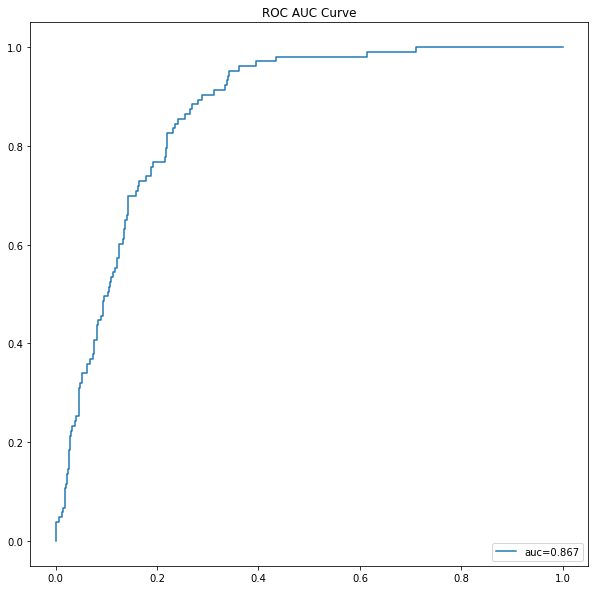

In [106]:
plt.figure(figsize=(10, 10))
plt.title('ROC AUC Curve')
plt.plot(fpr, tpr, label=f'auc={round(rocauc, 3)}')
plt.legend(loc=4)

print(classification_report(y_test, ypred))

#### Majority Class Undersampling

In [107]:
data.shape

(4261, 84)

In [108]:
data['crrt'].value_counts(dropna=False)

0.0    3918
1.0     343
Name: crrt, dtype: int64

In [109]:
nocrrt, crrt = data['crrt'].value_counts()

In [110]:
nocrrt_df = data[data['crrt'] == 0].reset_index(drop=True)
nocrrt_df_under = nocrrt_df.sample(n=crrt, random_state=2022)

In [111]:
crrt_df = data[data['crrt'] == 1].reset_index(drop=True)

In [112]:
under_sampled = pd.concat([crrt_df, nocrrt_df_under], axis=0).sample(frac=1)

In [113]:
under_sampled['crrt'].value_counts()

1.0    343
0.0    343
Name: crrt, dtype: int64

In [114]:
test_under, under_ytest, under_yHat = train_predict_lr(under_sampled, columns, numerical, categorical)

{'min_spo2': -0.25897498452785783, 'max_spo2': 0.37655559138942446, 'nanmin_valuenum_Albumin': -0.08313514997512735, 'nanmin_valuenum_Creatinine': -0.2763682924497214, 'nanmin_valuenum_Hematocrit': -0.2977995721278287, 'nanmin_valuenum_Potassium': 0.11818285398513934, 'nanmin_valuenum_Urea Nitrogen': -0.3004073779842946, 'nanmin_valuenum_pH': -0.9581853798000997, 'nanmax_valuenum_Albumin': 0.09545573002984058, 'nanmax_valuenum_Creatinine': 1.6427651877266145, 'nanmax_valuenum_Hematocrit': -0.08176838663363271, 'nanmax_valuenum_Potassium': -0.15089975031125905, 'nanmax_valuenum_Urea Nitrogen': -0.06549859119009996, 'nanmax_valuenum_pH': 0.049242873493760525, 'ckd': 0.18702395655659723, 'dm': -0.13150224034686253, 'hypertension': 0.13160136431339772, 'heartfailure': 0.06753971926200047, 'race': -0.06744059529546413, 'gender': 0.0887929887864739, 'BMI': -0.08869386481994254}


In [115]:
coef = {'min_spo2': -0.4852047853834246, 'max_spo2': 0.1275742150991979, 'nanmin_valuenum_Albumin': -0.20834890296303632, 'nanmin_valuenum_Creatinine': -0.27070791975477343, 'nanmin_valuenum_Hematocrit': -0.029813067747945267, 'nanmin_valuenum_Potassium': 0.12755607056666335, 'nanmin_valuenum_Potassium, Whole Blood': -0.6214020245588742, 'nanmin_valuenum_Urea Nitrogen': -0.2587734578499637, 'nanmin_valuenum_pH': -1.5201620121199284, 'nanmax_valuenum_Albumin': 0.31521468315400913, 'nanmax_valuenum_Creatinine': 1.524030435521787, 'nanmax_valuenum_Hematocrit': -0.17537377615311694, 'nanmax_valuenum_Hematocrit, Calculated': -0.07035163086763366, 'nanmax_valuenum_Potassium': 0.2538660824177118, 'nanmax_valuenum_Potassium, Whole Blood': 0.9666497534717178, 'nanmax_valuenum_Urea Nitrogen': 0.4160818026598768, 'nanmax_valuenum_pH': 2.0042514398732734, 'ckd': 0.08715115694850646, 'dm': 0.05534529373130768, 'hypertension': 0.06822913953444272, 'heartfailure': 0.02438402149205089}


In [116]:
coef

{'min_spo2': -0.4852047853834246,
 'max_spo2': 0.1275742150991979,
 'nanmin_valuenum_Albumin': -0.20834890296303632,
 'nanmin_valuenum_Creatinine': -0.27070791975477343,
 'nanmin_valuenum_Hematocrit': -0.029813067747945267,
 'nanmin_valuenum_Potassium': 0.12755607056666335,
 'nanmin_valuenum_Potassium, Whole Blood': -0.6214020245588742,
 'nanmin_valuenum_Urea Nitrogen': -0.2587734578499637,
 'nanmin_valuenum_pH': -1.5201620121199284,
 'nanmax_valuenum_Albumin': 0.31521468315400913,
 'nanmax_valuenum_Creatinine': 1.524030435521787,
 'nanmax_valuenum_Hematocrit': -0.17537377615311694,
 'nanmax_valuenum_Hematocrit, Calculated': -0.07035163086763366,
 'nanmax_valuenum_Potassium': 0.2538660824177118,
 'nanmax_valuenum_Potassium, Whole Blood': 0.9666497534717178,
 'nanmax_valuenum_Urea Nitrogen': 0.4160818026598768,
 'nanmax_valuenum_pH': 2.0042514398732734,
 'ckd': 0.08715115694850646,
 'dm': 0.05534529373130768,
 'hypertension': 0.06822913953444272,
 'heartfailure': 0.02438402149205089}

In [117]:
# ['a_patientid', 'albumine_min', 'albumine_max', 'potassium_min',
#        'potassium_max', 'spo2_min', 'spo2_max', 'haematocrit_min',
#        'haematocrit_max', 'ph_min', 'ph_max', 'bun_min', 'bun_max', 'diabetes',
#        'heart failure', 'hypertension', 'chronic kidney disease', 'RRT',
#        'crrt_time', 'aki_stage']

(array([45., 24., 16.,  8., 12., 13., 17., 16., 27., 28.]),
 array([0.00184949, 0.10141089, 0.20097228, 0.30053368, 0.40009507,
        0.49965647, 0.59921786, 0.69877926, 0.79834065, 0.89790204,
        0.99746344]),
 <BarContainer object of 10 artists>)

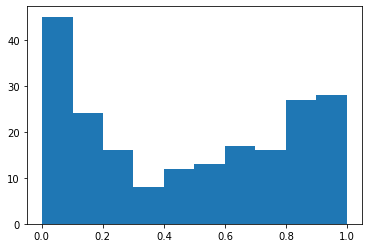

In [118]:
plt.hist(under_yHat[:, 1])

In [119]:
fpr, tpr, _ = roc_curve(under_ytest, under_yHat[:,1])
rocauc = auc(fpr, tpr)

In [120]:
ypred_under = (under_yHat[:, 1] >= 0.5)

              precision    recall  f1-score   support

         0.0       0.82      0.83      0.83       103
         1.0       0.83      0.82      0.82       103

    accuracy                           0.83       206
   macro avg       0.83      0.83      0.83       206
weighted avg       0.83      0.83      0.83       206



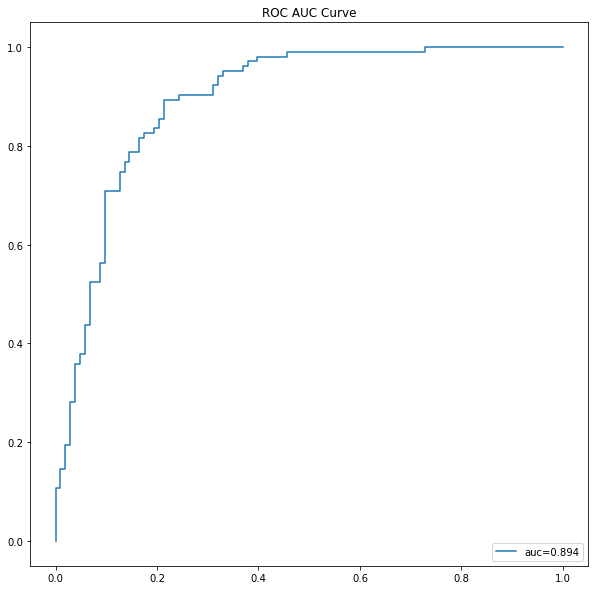

In [121]:
plt.figure(figsize=(10, 10))
plt.title('ROC AUC Curve')
plt.plot(fpr, tpr, label=f'auc={round(rocauc, 3)}')
plt.legend(loc=4)

print(classification_report(under_ytest, ypred_under))

In [122]:
# Stratify by AKI stage.
test_under['prediction'] = under_yHat[:, 1]

/tmp/ipykernel_54805/532204791.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_under['prediction'] = under_yHat[:, 1]


Text(0.5, 1.0, 'Performance by AKI')

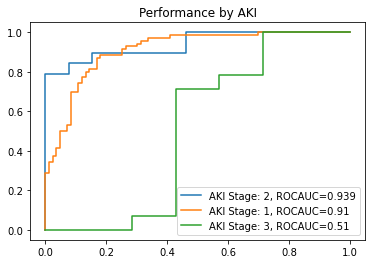

In [123]:
# Plot ROC curves for AKI stratified by stage.
for aki in test_under['aki_stage'].unique():
    tmp = test_under[test_under['aki_stage'] == aki]
    ytest = tmp['crrt'].ravel()
    ypred = tmp['prediction'].values
    fpr, tpr, _ = roc_curve(ytest, ypred)
    rocauc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'AKI Stage: {aki}, ROCAUC={round(rocauc, 3)}')
plt.legend(loc=4)
plt.title("Performance by AKI")

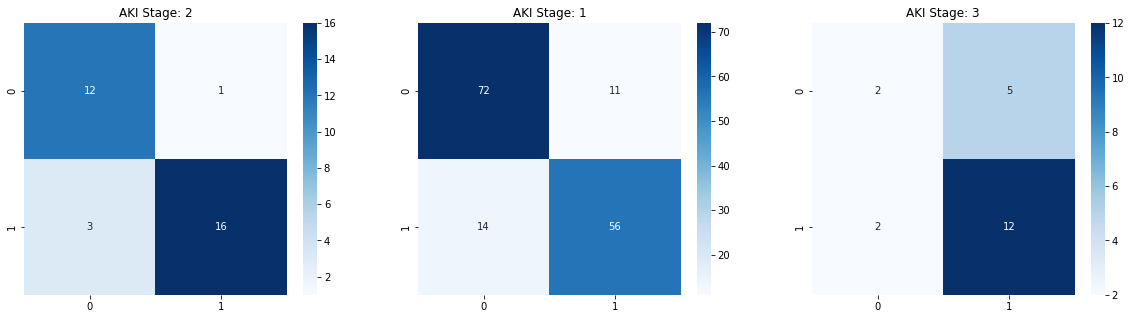

In [124]:
# Confusion matrices.
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, aki in enumerate(test_under['aki_stage'].unique()):
    tmp = test_under[test_under['aki_stage'] == aki]
    ytest = tmp['crrt'].ravel()
    ypred = tmp['prediction'].values
    ypred = (ypred >= 0.5)
    cm = confusion_matrix(ytest, ypred)
    sns.heatmap(cm, annot=True, ax=ax[i], cmap='Blues')
    ax[i].set_title(f'AKI Stage: {aki}')

In [125]:
test_under['time_delta'].describe()

count    103.00000
mean      62.44835
std       32.73720
min       24.38472
25%       33.57514
50%       52.87778
75%       81.50833
max      142.28611
Name: time_delta, dtype: float64

Text(0.5, 1.0, 'Performance by Time')

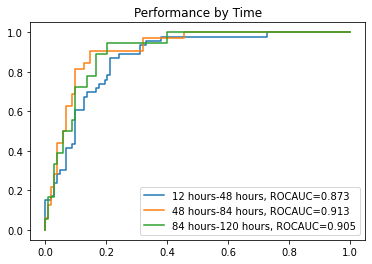

In [126]:
# Plot ROC curves for AKI stratified by stage.
step = 36
for i in range(12, 120, step):
    lower_bound = i
    upper_bound = i + step
    tmp = test_under[((test_under['time_delta'] >= lower_bound) & (test_under['time_delta'] <= upper_bound)) | (test_under['crrt'] == 0)]
    ytest = tmp['crrt'].ravel()
    ypred = tmp['prediction'].values
    fpr, tpr, _ = roc_curve(ytest, ypred)

    rocauc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{i} hours-{i+step} hours, ROCAUC={round(rocauc, 3)}')
plt.legend(loc=4)
plt.title("Performance by Time")

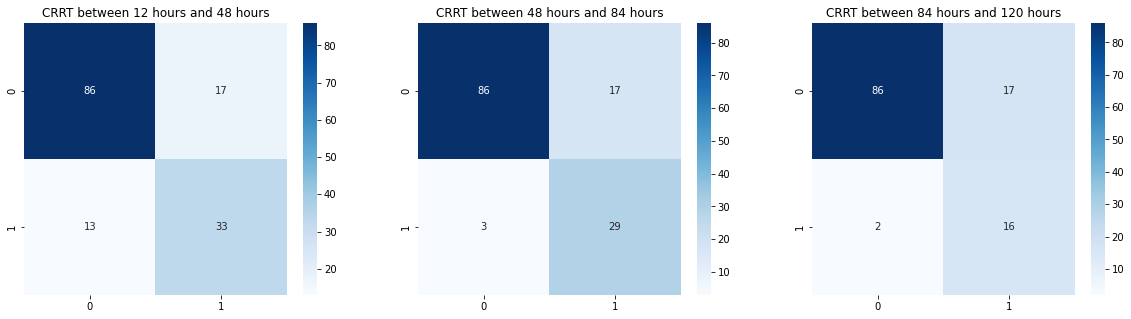

In [127]:
# Confusion matrices.
step = 36
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
counter = 0
for i in range(12, 120, step):
    lower_bound = i
    upper_bound = i + step
    tmp = test_under[((test_under['time_delta'] >= lower_bound) & (test_under['time_delta'] <= upper_bound)) | (test_under['crrt'] == 0)]
    ytest = tmp['crrt'].ravel()
    ypred = tmp['prediction'].values
    ypred = (ypred >= 0.5)
    cm = confusion_matrix(ytest, ypred)
    sns.heatmap(cm, annot=True, ax=ax[counter], cmap='Blues')
    ax[counter].set_title(f'CRRT between {lower_bound} hours and {upper_bound} hours')
    counter+=1